# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import datetime
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


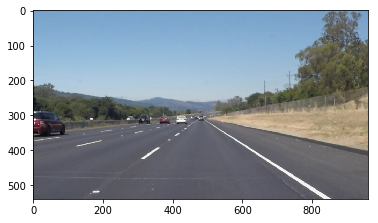

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(graye)"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness= 5)
    return  lines, line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'y_challenge1.jpg',
 'y_challenge2.jpg',
 'y_challenge3.jpg',
 'y_challenge4.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

#### The Pipeline consists of:
* [Color Selection](#"Color Selection")
* [Gray scaling and Smoothing the Image](#Grayscaling and Smoothing the Image)
* [Canny Edge Detection](#Canny Edge Detection)
* [Hough Transform](#Hough Transform)
* [Extrapolating Lane lines](#Extrapolating Lane lines)

**Note: In the coming sections we'll be applying each step of the *pipeline* on *all* of the test images to get a good idea of the performance on a multitude of different examples.**


In [5]:
def show_images(images, image_name= '',cmap= None):
    SAVE_DIR = 'test_images_output/'
    directory = ''
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    if os.path.isdir(SAVE_DIR): 
        directory = SAVE_DIR
    image_name = str(datetime.datetime.now()).split('.')[0].replace(' ', '').replace(':','').replace('-', '') if image_name == '' else image_name
    plt.savefig(directory + image_name + '.png', bbox_inches = 'tight')
    plt.show()

In [6]:
# Read in the test images
test_images = [mpimg.imread("test_images/" + image_name) for image_name in os.listdir("test_images/")]

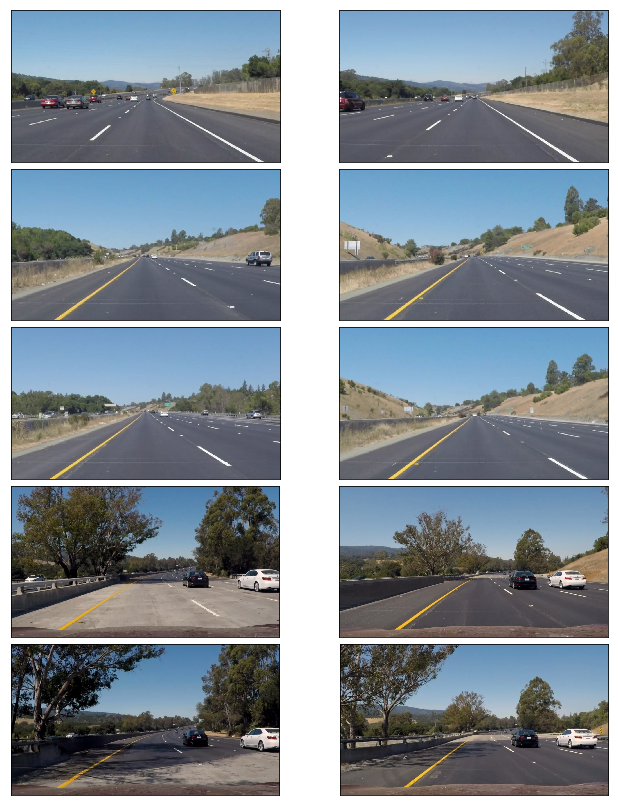

In [7]:
show_images(test_images, image_name='all_test_images')

## Color Selection
----
Here we want to apply multiple strategies to try and get the **white** and **yellow** lane lines from our images.

### RGB filtering

Here we apply masks to the image to only select the **White** and **Yellow** object within our image.

In [8]:
def select_white_yellow_colors(image):
    # White color mask
    
    lower_white = np.uint8([200, 200, 200])
    upper_white = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    
    # Yellow color mask
    
    lower_yellow = np.uint8([190, 190,   0])
    upper_yellow = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_yellow, upper_yellow)
    
    # One mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask) 
    return masked_image

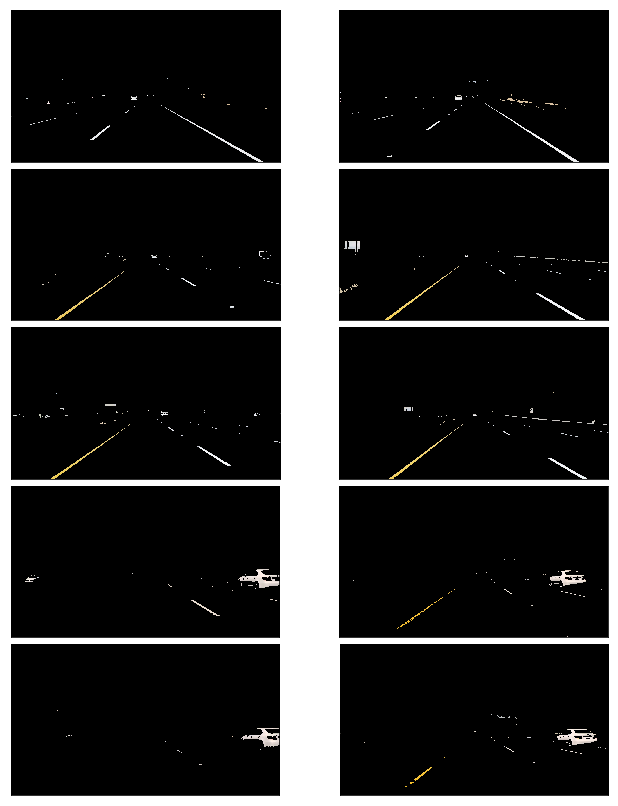

In [9]:
show_images(list(map(select_white_yellow_colors, test_images)),  image_name='rgb_filtered_test_images')

While this yield decent results we can see that for other images like the ones in the challenge video some of the 
lines will be a lot darker than others due to shadows from objects like trees and clouds. So we need to explore other 
color spaces to solve this problem. **HSV** (Hue, Saturation, Value) and **HSL** (Hue, Saturation, Lightness) are two good candidates cause we can change their saturation and in the case of **HSV** we can even play with *Lightness*

You can checkout how to convert to different color spaces in `OpenCV` [here](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) 

### Convert to HSV

In [10]:
def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

### Convert To HSL

In [11]:
def convert_to_hsl(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

### Lets compare the results from HSV and HSL 

In [12]:
hsv_images = list(map(convert_to_hsv, test_images))
hsl_images = list(map(convert_to_hsl, test_images))

#### HSV Images

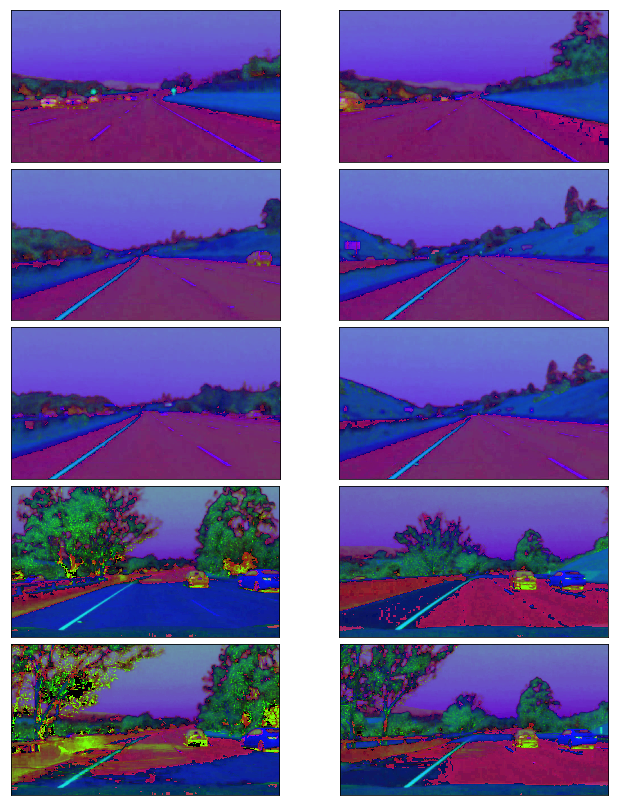

In [13]:
show_images(hsv_images, image_name='hsv_test_images')

As you can see in the images above the white lines faded in the image especially the white dotted lines;However, it clearly highlights the lane lines that are in the shade in the bottom 4 images. So apparently `HSV` gives us the lane lines in the shade that we couldn't identify our `RGB` mask, but it fails to clearly identify other lines like in the first 2 images. Lets checkout the `HSL` image hopefully we'll have better luck with them. 

#### HSL Images

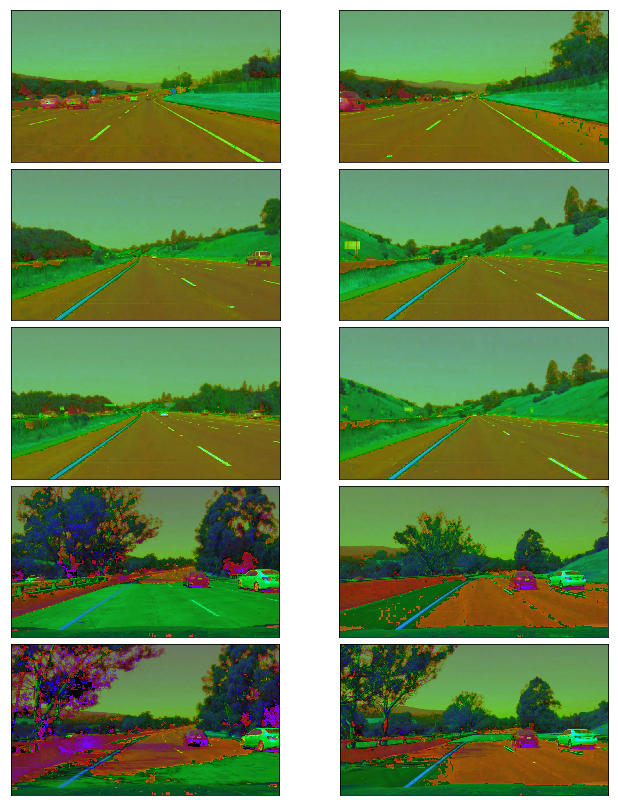

In [14]:
show_images(hsl_images, image_name='hsl_test_images')

As we can see in the images above all lane lines are clear even the ones in the shade and the ones on bright surfaces. Now we need to build out ***white*** and ***yellow*** masks to filter the image for the only these colors.

### Select Color

As we can see the `HSL` color space shows clearly defined lane lines so be it a Yellow or a while lane line. 
You can also see the yellow colored lane lines as bluish hued lines. Now we need to *select* the lane lines as we did above, but here we'll do this by applying masks with changing the H(hue) S(saturation) L(lightness). We'll create a `select_white_yellow_colors_HSL` method just like our previous `select_white_yellow_colors` method to select our **white** and **yellow** lines, but this time we'll do it to the HSL image.

In [15]:
def select_white_yellow_colors_HSL(image):
    
    # Convert the image to HSL
    hsl_image = convert_to_hsl(image)
    # White color mask
    
    lower_white = np.uint8([0, 200, 0])
    upper_white = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hsl_image, lower_white, upper_white)
    
    # Yellow color mask
    
    lower_yellow = np.uint8([10, 0, 100])
    upper_yellow = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(hsl_image, lower_yellow, upper_yellow)
    
    # One mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask) 
    return masked_image

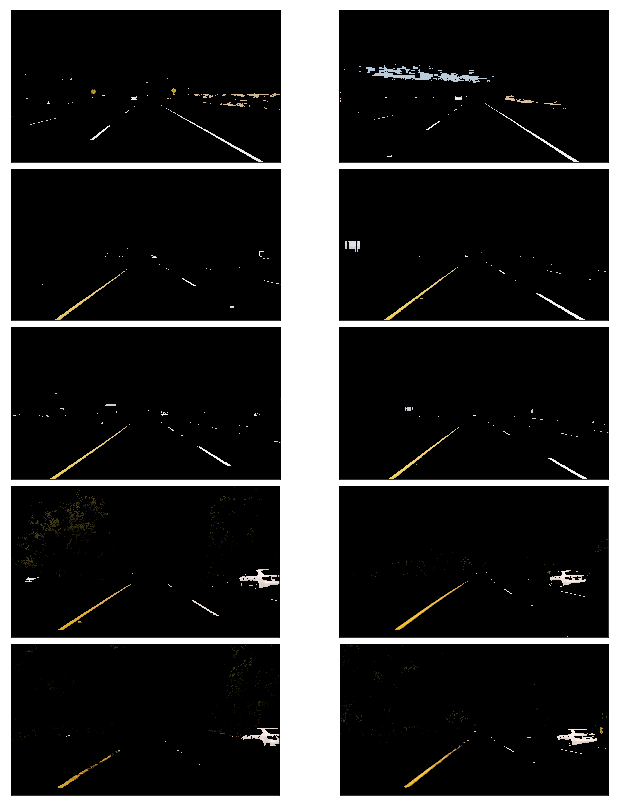

In [16]:
white_yellow_lines = list(map(select_white_yellow_colors_HSL, test_images))
show_images(white_yellow_lines, image_name='white_yellow_filtered_hsl_images')

 ## Grayscaling and Smoothing the Image 
 ____
 
 In this section we `grayscale` our *image* to get it ready for `Canny` edge detection, we also need to smooth
 our image to have sleek and better edges for the `Canny` edge to detect.

### Gray scale the image

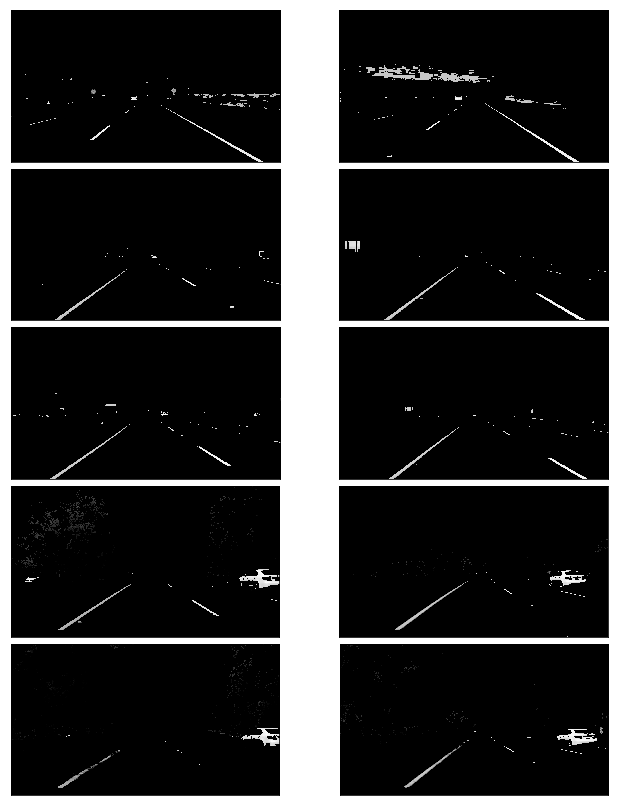

In [17]:
# grayscaling the image
# gray = grayscale(select_white_yellow_colors(test_images[0]))
gray = list(map(grayscale, white_yellow_lines))

show_images(gray, image_name='grayscaled_test_images')

### Gaussian Blur smoothing

Here we smooth our `grayscaled` image using `Gaussian Blur` before we apply `Canny edge detection`, I found that a `filter size` of **11** does a nice job on most all the sample images. We can also use other **odd** values as our `filter size`, but I found that **11** is an ok enough value. Though `Canny Edge Detection` applies *smoothing* internally, we can't change the filter size so prior smoothing is **recommended** as a good practice.

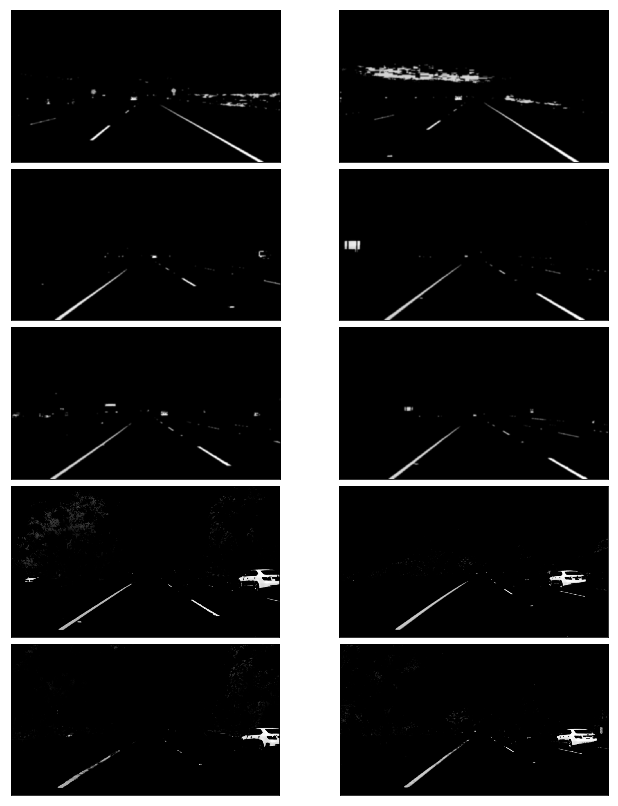

In [18]:
# We apply Gaussian Blur to denoise the Gray image before getting canny edges 
denoised_gray = [gaussian_blur(x, 11) for x in gray]

show_images(denoised_gray, image_name='smooth_test_images')

## Canny Edge Detection
---

`Canny Edge Detection` is an algorithm that was developed by ** John F. Canny** in 1986, where it takes a `grayscale` image and finds edges in the image where there is a shift or change in **Gradient**. We can set our boundaries for acceptable edges by setting the *high* and *low* thresholds represented as `high_threshold` and `low_threshold` respectively. `Canny Edges Detection` has multiple processes internally, and you can learn all about it [here](https://en.wikipedia.org/wiki/Canny_edge_detector) .

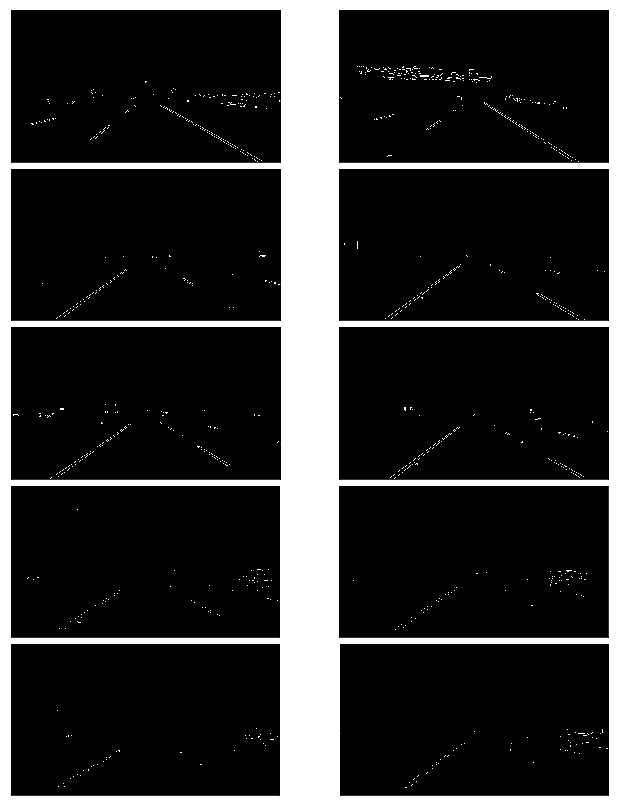

In [19]:
# Here we detect the image's edges using Canny edge detection
def canny_edges(image, low_threshold = 50, high_threshold = 150):
    return canny(image, low_threshold, high_threshold)

canny_images = list(map(canny_edges, denoised_gray))
show_images(canny_images, image_name='canny_test_images')

## Applying Mask (Region of interest)
---

In this section of the pipeline after selecting our colors, gray scaling, smoothing, and getting our image's Canny edges we remove all the unimportant parts of the image like other lane lines, trees, sky, etc. and we focus on the road ahead. We achieve this by choosing a region of interest, we'll be using the `region_of_interest` method provided in the helper methods. The method takes two arguments the *image* and am array or *vertices* that make up a polygon, it sets any pixel thats out side the polygon to *zero* (black) and leaves the pixels within the polygon intact. This will give us an image thats mostly black and white where the edges are within the defined polygon's borders. 

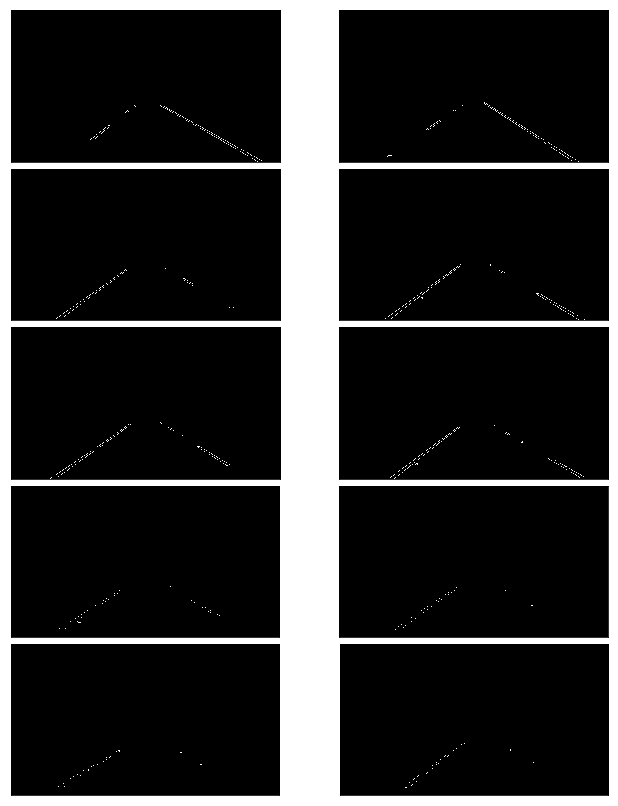

In [20]:
def apply_region_of_interest(image):
    # four sided polygon as a mask
    imshape = image.shape
    xsize = imshape[1]
    ysize = imshape[0]
    # Top-Left, Top-right, Bottom-right, Bottom-left 
    vertices = np.array([[(xsize * 0.05, ysize) # Bottom left
                     , (xsize * 0.45, ysize * 0.60)  # Top left vertix 60% if the image's hight
                     , (xsize * 0.55, ysize * 0.60) # Top right vetrix 
                     , (xsize * 0.95, ysize)]] # Bottom right
                        , dtype=np.int32)
    return region_of_interest(image, vertices)

masked_edges_images = list(map(apply_region_of_interest, canny_images)) 
show_images(masked_edges_images, image_name='regionofinterest_test_images')


As you can see we get a good representation of the outlines of the lane lines, the region of interest's bottom is set to the image bottom and its top to 60% of the image hight (just below the image center) and I think that that is a good estimate for the horizon, at least for the given images. Also it spans the image with a little padding 5% and narrows towards the top of the image with a width of 10%, this gives a good representation of a road with its lane lines narrowing toward the horizon.   

**Note: I think that there is a better more dynamic way of detecting the road's horizon.**

## Hough Transform
___

Hough Transform is an technique (algorithm) that helps us identify lines in an image given a set of point on that image, in this case its `Canny edges` result. Hough transform uses something called ***Hough space*** which was create by **Paul Hough** in 1962, each point in **Image space** (white dots in our case) corresponds to a *sine wave* in **Hough space**, and if some points in image space lay on the same line in **Image space** this corresponds to an intersection (Hough point) of the points *sine waves*. One parameter of the `hough_lines` method is `threshold` which is the minimum number of intersections(votes) in **Hough space** to constitute a line in **Image space**. for more on Hough Transform visit: https://en.wikipedia.org/wiki/Hough_transform     

#### Hough Space examples:

![alt text](my_report_images\udacity_hough.png "udacity Hough Space")

In [21]:
def hough_transform(image):
    # Apply Hough transform on the Canny edged image
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = 1 * (np.pi/180) # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments

    return hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)

images_hough_lines = list(map(hough_transform , masked_edges_images))

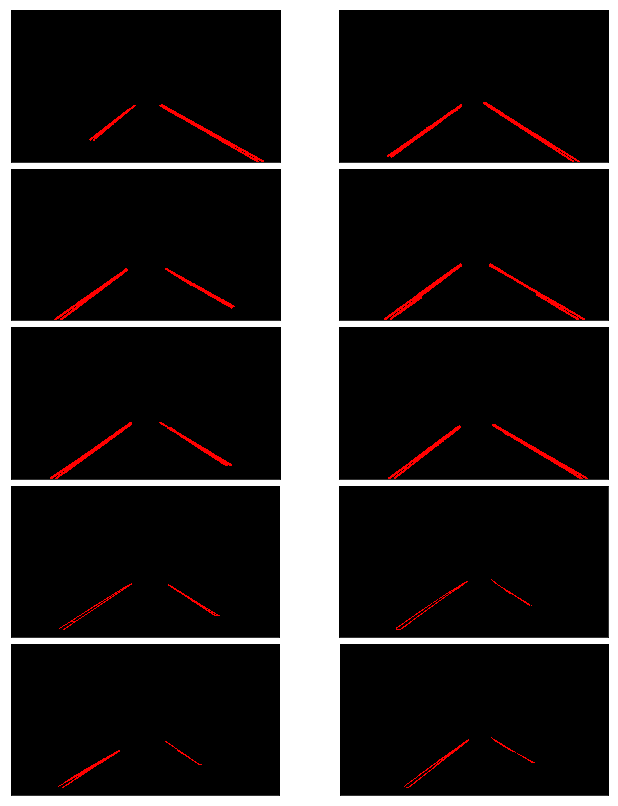

In [22]:
show_images([line_img for _, line_img in images_hough_lines], image_name='hough_lines_test_images')

### Draw Lines on Image

I altered the return type of the `hough_lines` in the helpers methods to also return a list of lines along with the image with lines drawn on them, that will help in the next section where these lines will be divided into right and left lane lines, averaged, and weighted to produce the best fit for the lane lines.

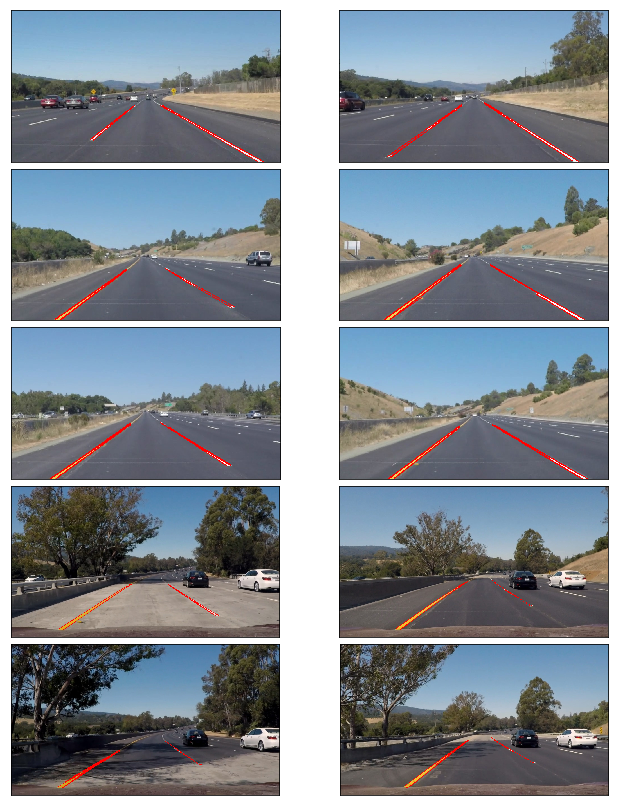

In [23]:
images_copies = [np.copy(img) for img in test_images]
lines_images = []
for image, lines in zip(images_copies, images_hough_lines):
    draw_lines(image, lines[0])
    lines_images.append(image)

show_images(lines_images, image_name='hough_test_images')

As we can see in the images above the lane lines are clearly identified and a red line is drawn over the line segments connecting most dashed lines segments; however, we can still see the gaps in some of images. 

## Extrapolating Lane lines
___


After finding our lane lines and marking them we can still go a step further and try and extrapolate (extend) our lane lines to have two continues lane lines from the bottom of the image towards the horizon (60% of the image). We'll Achieve this by:

* [Averaging LaneLines](#Averaging LaneLines)
* [Making Lines to Draw](#Making Lines to Draw)
* [Drawing Lane Lines](#Drawing Lane Lines)

### Averaging LaneLines

The `average_slope_yintercept` method below will return two lane lines (slope, y-intercept) by dividing our lane lines as left and right using their slopes *negative* slope means *left lane* and *positive* means *right lane*, then we'll average each lane line slopes and y-intercepts to get a single line for each lane. Also we'll use each line's length as a weight to give more consideration to lines that are longer in length. 

In [24]:
def average_slope_yintercept(lines):
    left_lane_lines = [] 
    left_lane_weights = []
    right_lane_lines = [] 
    right_lane_weights = [] 
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - slope * x1
            
            # Right lane line
            line_length = np.sqrt((y2-y1)**2 + (x2-x1)**2 )
            if slope > 0: 
                right_lane_lines.append((slope, y_intercept))
                right_lane_weights.append((line_length))
            # Left lane line
            else:
                left_lane_lines.append((slope, y_intercept))
                left_lane_weights.append((line_length))
    
    # Weight slopes and Y_intercepts by their line lenght
    right_lane = np.dot(right_lane_weights, right_lane_lines) / np.sum(right_lane_weights) if len(right_lane_weights) > 0 else None
    left_lane  = np.dot(left_lane_weights,  left_lane_lines) / np.sum(left_lane_weights)  if len(left_lane_weights) > 0 else None
    
    return right_lane, left_lane

### Making Lines to Draw

So we got the averaged slope and y-intercept for each lane line cool what now?
Well according to middle school math class `y = mx + b` is the equation on a straight line where:
* `m` is the slope of the line which we got (yay)
* `b` is the y-intercept which we also have double (yay), we're almost done. 

But wait what about the other two variables the points of the line? 
Well `x` is unknown, but `y` will be the upped and lower bounds of our region of interest, so we only need to find `x` which we can do with a simple substitution `x = (y - b) / m`

In [25]:
def make_points(y1, y2, line):
    if line is None:
        return None

    slope, intercept = line

    x1 = int((y1 - intercept)/slope)
    y1 = int(y1)
    x2 = int((y2 - intercept)/slope)
    y2 = int(y2)

    return ((x1, y1), (x2, y2))

def make_lane_lines(image, lines):
    right_lane, left_lane = average_slope_yintercept(lines)#seperate_lanelines(lines)
    
    y1 = image.shape[0] # Y value Opencv has everything inverted
    y2 = y1 * 0.60 

    right_line = make_points(y1, y2, right_lane)
    left_line  = make_points(y1, y2, left_lane)
    
    return right_line, left_line    

### Drawing Lane Lines

I decided to make `draw_lane_lines` method to handle drawing the extrapolated lane lines instead of altering `draw_lines` method for better code organization.

In [26]:
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=2):
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for line in lines:
        if line:
            cv2.line(line_img, *line, color, thickness)
    return weighted_img(image, line_img)

In [27]:
extrapolated_lane_lines_list = [make_lane_lines(img, hough_lines[0]) for img, hough_lines in zip(test_images, images_hough_lines)]
images_copies = [np.copy(img) for img in test_images]
lane_lines_images = []

for image, lane_lines in zip(images_copies, extrapolated_lane_lines_list):
    lane_lines_images.append(draw_lane_lines(image, lane_lines, thickness=18))

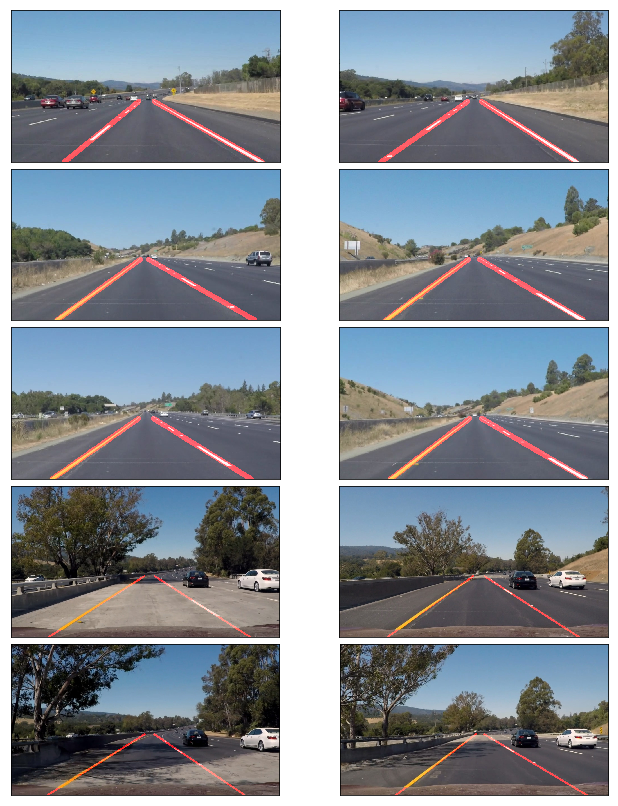

In [28]:
show_images(lane_lines_images, image_name='extrapolated_test_images')

As we can see here it seems that all went according to plan and all the lines drawn extend the full length of the left and the right lane lines, all that remains now is to test it on the test videos.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

### The Complete Pipeline

After applying the pipeline on the first video `solidWhiteRight` the result seemed ok though the lines were a little jittery. 

However, after applying it to the second video `solidYellowLeft` the lane lines crossed each other for a second as you can see here: 
![alt text](my_report_images/crossed_lines.png "Crossed lines")

Since as we know the video plays for 60 frames per second and each frame is an image, therefore we need to average the frames' lines to have a smoother and more consistent lane lines.

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
from collections import deque

class LaneLineFinder:
    
    SAMPLE_FRAMES = 30
    
    def __init__(self):
        self.right_lane_lines = deque(maxlen= self.SAMPLE_FRAMES) 
        self.left_lane_lines = deque(maxlen= self.SAMPLE_FRAMES)
        
    def average_line_sampling(self, line, previous_lines):
        if line:
            previous_lines.append(line)
        
        if len(previous_lines) > 0:
            line = np.mean(previous_lines, axis = 0, dtype=np.int32) # Like tensorflow
            line = tuple(map(tuple, line))
            
        return line
        
    def process_image(self, image):
        # NOTE: The output you return should be a color image (3 channel) for processing video below
        # TODO: put your pipeline here,
        # you should return the final output (image where lines are drawn on lanes)

        # Convert image to the HSL color space 
        white_yellow_image = select_white_yellow_colors_HSL(image)
        # grayscaling the image
        gray_image = grayscale(white_yellow_image)

        # then we apply Gaussian Blur to denoice the Gray image before getting canny edges
        # Denoise image using Gaussian Blur
        denoised_image = gaussian_blur(gray_image, 11)

        # then we apply canny edges to detect the image edges
        canny_image = canny_edges(denoised_image)


        # Apply region of intrest mask on the canny edges image
        masked_image = apply_region_of_interest(canny_image)


        # Apply Hough transform on the Canny edged image
        # Applying Hough transform and drawing the lines on the image
        image_lines = hough_transform(masked_image)

        # Extrapolate lanelines return by the Hough transform
        extrapolated_lane_lines = make_lane_lines(image, image_lines[0])
        
    
        # Average the videos last 6 lines' frames  
        right_line = self.average_line_sampling(extrapolated_lane_lines[0], self.right_lane_lines)
        left_line = self.average_line_sampling(extrapolated_lane_lines[1], self.left_lane_lines)

        # Draw laneLines on the mage with lane lines colored 
    #     image_copy = np.copy(image)

        return draw_lane_lines(image, (right_line, left_line), thickness= 18)

Above I made a `class` called `LaneLineFinder`:
* `SAMPLE_FRAMES` is a *constant* number of frames to average across
* `right_lane_lines` and `left_lane_lines` are two `deque` (queue in python) variables of length `SAMPLE_FRAMES`  
* `average_line_sampling` gets the average of the previous `SAMPLE_FRAMES` frames using numpy `np.mean` method
* `process_image` which executes the pipeline

### A little test of the combined pipeline

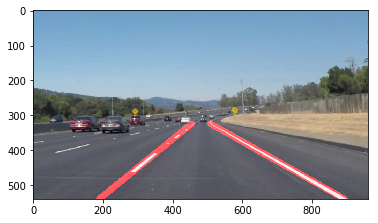

In [31]:
lane_line_finder = LaneLineFinder()

x = lane_line_finder.process_image(test_images[0])
plt.imshow(x)

Let's try the one with the solid white lane on the right first ...

In [32]:
lane_line_finder = LaneLineFinder()
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_line_finder.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 61.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 3.94 s


In [33]:
#Close the reader properly 
clip1.reader.close()
clip1.audio.reader.close_proc()

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [35]:
lane_line_finder = LaneLineFinder()
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lane_line_finder.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:10<00:00, 67.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 10.4 s


In [36]:
#Close the reader properly 
clip2.reader.close()
clip2.audio.reader.close_proc()

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [38]:
lane_line_finder = LaneLineFinder()
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(lane_line_finder.process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:07<00:00, 35.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 7.65 s


In [39]:
#Close the reader properly 
clip3.reader.close()
clip3.audio.reader.close_proc()

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))